In [1]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    
    # Introduced a new layer to scale the architecture for image of size 512 * 512
    # Downsampling
    
    
    ##Layer 1:
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    
    ##Layer 2:
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    ##Layer 3:
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    ##Layer 4:
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    ##Layer 5:
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    #########Bottleneck
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    
    #Upsampling
    
    ## Upsampling layer 5:
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    ## Upsampling Layer 4:
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    ## Upsampling Layer 3:
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    ## Upsamplng Layer 2:
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    ## Upsampling Layer 1:
    up10 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv,up10])
    conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    
    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    conv11 = Conv2D(1, 1, activation = 'sigmoid')(conv10)

    model = Model(input = inputs, output = conv11)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [4]:
model1 =unet()
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/home/ravitha/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [6]:

def adjustData(img,mask):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)


In [5]:
PATH='/home/ravitha/D/Datasets/TNBC Dataset'

In [8]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "Image",mask_save_prefix  = "Mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = PATH + '/aug',target_size = (512,512),seed = 1):


    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    # Provide the same seed and keyword arguments to the fit and flow methods
    #seed = 1
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)


In [9]:
data_gen_args = dict(rotation_range=0.2,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05,zoom_range=0.05,horizontal_flip=True, fill_mode='nearest')

In [10]:
myGene = trainGenerator(10,PATH,'Image','Mask',data_gen_args,save_to_dir = PATH + '/aug',target_size=(512,512))

In [11]:
model_checkpoint = ModelCheckpoint('unet_Final.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [12]:
model1.fit_generator(myGene,steps_per_epoch=35,epochs=64,callbacks=[model_checkpoint])

Epoch 1/64
Found 39 images belonging to 1 classes.
Found 39 images belonging to 1 classes.
35/35 [==============================] - 30s 856ms/step - loss: 0.4215 - acc: 0.8275

Epoch 00001: loss improved from inf to 0.42301, saving model to unet_Final.hdf5
Epoch 2/64
35/35 [==============================] - 21s 588ms/step - loss: 0.3093 - acc: 0.8785

Epoch 00002: loss improved from 0.42301 to 0.30872, saving model to unet_Final.hdf5
Epoch 3/64
35/35 [==============================] - 21s 599ms/step - loss: 0.2663 - acc: 0.8935

Epoch 00003: loss improved from 0.30872 to 0.26587, saving model to unet_Final.hdf5
Epoch 4/64
35/35 [==============================] - 21s 605ms/step - loss: 0.2304 - acc: 0.9051

Epoch 00004: loss improved from 0.26587 to 0.23094, saving model to unet_Final.hdf5
Epoch 5/64
35/35 [==============================] - 21s 608ms/step - loss: 0.2142 - acc: 0.9111

Epoch 00005: loss improved from 0.23094 to 0.21408, saving model to unet_Final.hdf5
Epoch 6/64
35/35 [=

35/35 [==============================] - 21s 613ms/step - loss: 0.0577 - acc: 0.9756

Epoch 00048: loss improved from 0.06048 to 0.05775, saving model to unet_Final.hdf5
Epoch 49/64
35/35 [==============================] - 22s 620ms/step - loss: 0.0578 - acc: 0.9755

Epoch 00049: loss did not improve from 0.05775
Epoch 50/64
35/35 [==============================] - 21s 611ms/step - loss: 0.0561 - acc: 0.9762

Epoch 00050: loss improved from 0.05775 to 0.05595, saving model to unet_Final.hdf5
Epoch 51/64
35/35 [==============================] - 22s 615ms/step - loss: 0.0548 - acc: 0.9768

Epoch 00051: loss improved from 0.05595 to 0.05487, saving model to unet_Final.hdf5
Epoch 52/64
35/35 [==============================] - 21s 609ms/step - loss: 0.0557 - acc: 0.9764

Epoch 00052: loss did not improve from 0.05487
Epoch 53/64
35/35 [==============================] - 22s 622ms/step - loss: 0.0553 - acc: 0.9766

Epoch 00053: loss did not improve from 0.05487
Epoch 54/64
35/35 [============

In [6]:
def testGenerator(testaug_dict,test_path):
  
    testimage_datagen = ImageDataGenerator(**testaug_dict)
    #seed = 1
    testimage_generator = testimage_datagen.flow_from_directory(
        PATH,
        class_mode = None,
        classes = ['Test_Image'],
        color_mode = 'grayscale',
        target_size = (512,512),
        batch_size = 1,
        save_to_dir = PATH + '/testaugimg', seed=1)
    for img in testimage_generator:
        img = img / 255
        yield img

In [7]:
testdata_gen_args=dict()
testGene = testGenerator(testdata_gen_args,PATH + '/Test_Image')

In [8]:
model2 = unet()
model2.load_weights("unet_Final.hdf5")
results = model2.predict_generator(testGene,11,verbose=0)

/home/ravitha/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Found 11 images belonging to 1 classes.


In [9]:
def saveResult(save_path,result):
    for (i,img) in enumerate(result):
        ####print(img.shape) ----> (512,512,1)
        img=img.reshape(512,512)
        ####print(img.shape) -----> (512,512)
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [10]:
saveResult(PATH+'/Results',results)

/home/ravitha/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


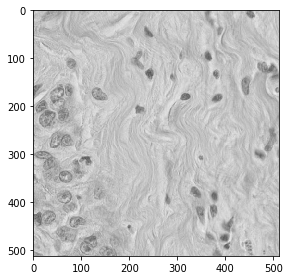

In [18]:
##### Testing for a single image without using testgenerator
import skimage.io as io
from skimage import color
import matplotlib.pyplot as plt
I = io.imread(PATH+'/Test_Image/01_7.png')
gray = color.rgb2gray(I)
io.imshow(gray)

In [20]:
model2 = unet()
model2.load_weights("unet_Final.hdf5")
results = model2.predict(gray.reshape(1,512,512,1),verbose=0)

/home/ravitha/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [21]:
print(results)

[[[[3.0111656e-02]
   [7.8128651e-03]
   [3.3485785e-03]
   ...
   [8.1770010e-03]
   [1.7473845e-02]
   [8.6401112e-02]]

  [[6.1734845e-03]
   [9.9943741e-04]
   [3.3604060e-04]
   ...
   [1.5101344e-03]
   [1.5428278e-03]
   [2.3925604e-02]]

  [[6.8414363e-04]
   [1.6347172e-04]
   [2.0757907e-04]
   ...
   [8.9907541e-04]
   [1.0047561e-03]
   [1.1443340e-02]]

  ...

  [[5.2590680e-01]
   [4.5323330e-01]
   [4.2837006e-01]
   ...
   [3.8729820e-03]
   [2.7843332e-02]
   [4.7485501e-02]]

  [[5.1086664e-01]
   [5.0918359e-01]
   [4.8222941e-01]
   ...
   [5.2519063e-03]
   [1.8556392e-02]
   [2.6058955e-02]]

  [[4.2314580e-01]
   [3.1805182e-01]
   [3.6049914e-01]
   ...
   [2.1511959e-02]
   [3.1549897e-02]
   [7.9605728e-02]]]]


TypeError: Invalid dimensions for image data

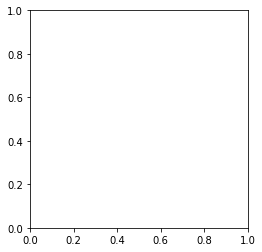